In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
# from keras.models import Sequential
# from keras import layers
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
import numpy as np
from transformers import AutoTokenizer
import torch
from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from datasets import load_dataset

# Load all data

In [80]:
# ds = load_dataset('jstonge1/data-statements-2024-05-31')
df = pd.read_parquet("data/annots/annotated_data.parquet")

In [82]:
# clean data
df = df[~df['sentiment'].str.contains('nan')]
df = df[df['sentiment'] != 'maybe']
df = df.drop_duplicates(subset='text')
df['sentiment_encoded'] = df.sentiment.map({'yes': 1, 'no': 0})

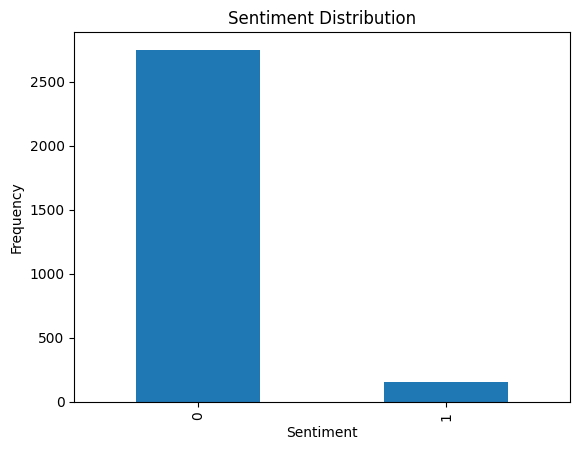

In [83]:
# plot distribution of sentiment
# ds['train'].to_pandas()['sentiment_encoded'].value_counts().plot(kind='bar')
df['sentiment_encoded'].value_counts().plot(kind='bar')
# show labels and axis
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment_encoded'], test_size=0.2, random_state=42)
# (X_train, y_train), (X_test, y_test) = (
#     (np.array(ds[split]['text']), np.array(ds[split]['sentiment_encoded'])) for split in ['train', 'test']
# )

## SVM

In [85]:
model = make_pipeline(TfidfVectorizer(), SVC())
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())])

In [87]:
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.9569707401032702
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       551
           1       1.00      0.17      0.29        30

    accuracy                           0.96       581
   macro avg       0.98      0.58      0.63       581
weighted avg       0.96      0.96      0.94       581



## Naive Bayes

In [60]:
# use naive bayes 
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [63]:
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

0.9543147208121827
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       376
           1       0.00      0.00      0.00        18

    accuracy                           0.95       394
   macro avg       0.48      0.50      0.49       394
weighted avg       0.91      0.95      0.93       394



/users/j/s/jstonge1/miniconda3/envs/catDB/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/j/s/jstonge1/miniconda3/envs/catDB/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/j/s/jstonge1/miniconda3/envs/catDB/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

## DNN - CNN

In [13]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [14]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [15]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

embedding_dim = 50

In [37]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

/users/a/c/achawla1/miniconda3/envs/llama_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
model.fit(X_train, y_train, epochs=10, verbose=False, validation_data=(X_test, y_test), batch_size=10)

In [39]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9974


In [40]:
# get confusion matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.963855421686747
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       551
           1       0.80      0.40      0.53        30

    accuracy                           0.96       581
   macro avg       0.88      0.70      0.76       581
weighted avg       0.96      0.96      0.96       581



## LSTM

In [42]:

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.LSTM(units=50))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/users/a/c/achawla1/miniconda3/envs/llama_env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [43]:
model.fit(X_train, y_train, epochs=10, verbose=False, validation_data=(X_test, y_test), batch_size=10)

In [44]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9858


In [45]:
# get confusion matrix
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
0.9586919104991394
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       551
           1       0.69      0.37      0.48        30

    accuracy                           0.96       581
   macro avg       0.83      0.68      0.73       581
weighted avg       0.95      0.96      0.95       581



## BERT


In [88]:
model_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [89]:
X_train = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt')
X_test = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='pt')

In [90]:
# train Bert
model = BertForSequenceClassification.from_pretrained(model_id, num_labels=2)
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [91]:
batch_size = 32
train_data = TensorDataset(X_train['input_ids'], X_train['attention_mask'], torch.tensor(y_train.tolist()))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [92]:
test_data = TensorDataset(X_test['input_ids'], X_test['attention_mask'], torch.tensor(y_test.tolist()))
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [93]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
device = 'cuda'

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        model.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print(f'Epoch: {epoch + 1}, Loss: {avg_train_loss}')

/users/j/s/jstonge1/miniconda3/envs/catDB/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Loss: 0.19781681216538768
Epoch: 2, Loss: 0.1219779606653403
Epoch: 3, Loss: 0.09209500560664559
Epoch: 4, Loss: 0.07384448687941449
Epoch: 5, Loss: 0.05965788154671454


In [96]:
# get confusion matrix
model.eval()
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        y_pred.extend(logits)

In [97]:
y_pred = [np.argmax(i) for i in y_pred]
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9569707401032702
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       551
           1       0.59      0.57      0.58        30

    accuracy                           0.96       581
   macro avg       0.78      0.77      0.78       581
weighted avg       0.96      0.96      0.96       581



## Roberta

In [102]:
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [104]:
# train Roberta
model = RobertaForSequenceClassification.from_pretrained(model_id, num_labels=2)
model.cuda()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [110]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
device = 'cuda'

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        model.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print(f'Epoch: {epoch + 1}, Loss: {avg_train_loss}')

/users/j/s/jstonge1/miniconda3/envs/catDB/lib/python3.9/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 1, Loss: 0.23721101767804526
Epoch: 2, Loss: 0.2051267453456578
Epoch: 3, Loss: 0.19922286675196804
Epoch: 4, Loss: 0.1907425973921606
Epoch: 5, Loss: 0.17919273330026295


In [111]:
# get confusion matrix
model.eval()
y_pred = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        y_pred.extend(logits)

In [112]:
y_pred = [np.argmax(i) for i in y_pred]
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.9483648881239243
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       551
           1       0.00      0.00      0.00        30

    accuracy                           0.95       581
   macro avg       0.47      0.50      0.49       581
weighted avg       0.90      0.95      0.92       581



/users/j/s/jstonge1/miniconda3/envs/catDB/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/j/s/jstonge1/miniconda3/envs/catDB/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/users/j/s/jstonge1/miniconda3/envs/catDB/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

## Llama-3-8B-Instruct

In [113]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import GenerationConfig, TextStreamer, pipeline
from inspect import cleandoc

In [134]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment_encoded'], test_size=0.2, random_state=42)

In [114]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map = 'auto'
)

# set the configs
generation_config = GenerationConfig.from_pretrained(model_id)
generation_config.max_new_tokens = 512
generation_config.temperature = 0.0001
generation_config.do_sample = True


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [115]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)
stop_token_ids = [tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")]

In [116]:
llm = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    generation_config=generation_config,
    num_return_sequences=1,
    eos_token_id=stop_token_ids,
    streamer=streamer,
)

#### Evaluate on the whole training data as we don't do training

In [ ]:
ex1 = """We thank A. Sachraida, C. Gould and P. J. Kelly for providing us with the experimental data and helpful comments, and S. Tomsovic for a critical discussion."""

ex2 = """River discharge data for the Tully River were obtained from the Queensland Bureau of Meteorology (http://www.bom.gov. au). No long-term in situ salinity data are available from King Reef; therefore, data from the Carton-Giese Simple Ocean Data Assimilation (SODA) reanalysis project were chosen as a longterm monthly resolution SSS dataset. This consists of a combination of observed and modeled data (Carton et al., 2000). Data were obtained from the box centered on 17.5°S (17.25°-17.75°) and 146°E (145.75°-146.25°). SODA version 1.4.2 extends from 1958 to 2001 and uses surface wind products from the European Center for Medium-Range Weather Forecasts 40-year reanalysis (ECMWF ERA 40), which may contain inaccuracies in tropical regions (Cahyarini et al., 2008). The most recent version of SODA (1.4.3) now uses wind data from the Quick-Scat scatterometer, thus providing more accurate data for the tropics (Cahyarini et al., 2008;Carton and Giese, 2008"""

ex3 = """The current results should be considered relative to a few study limitations. The CFS data did not specify the nature of proactive activities that patrol, DRT officers, or investigators were engaged in. Furthermore, although the coding of the ten call categories analyzed were informed by prior research (Wu & Lum, 2017), idiosyncrasies associated with the study departments' method of cataloging and recording call information did not always allow for direct comparisons to prior research on COVID-19's impact on police services. Similarly, measuring proactivity solely through self-initiated activities from CFS data is not a flawless indicator. Officers may engage in proactive work that is not captured in these **data** (Lum, Koper, et al., 2020). However, this method has been established as a reasonable way to distinguish proactivity from reactivity (Lum, Koper, et al., 2020;Wu & Lum, 2017;Zhang and Zhao, 2021)."""

run_llama3 = lambda x : llm([{
    "role": "user",
    "content": cleandoc(f"""
        Text: {ex1}
        is_data_availability_statement: yes

        Text: {ex2}
        is_data_availability_statement: yes

        Text: {ex3}
        is_data_availability_statement: no

        Text: {x}
        is_data_availability_statement: ?

        Give a one word response.
        """
    )}])

y_pred = list(map(run_llama3, X_train))

In [143]:
# we eyeballed the output to make sure it is all Yes/No
y_pred = list(map(lambda x: 1 if x[0]['generated_text'].lower() == 'yes' else 0, y_pred))

In [144]:
print(accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

0.6838931955211025
              precision    recall  f1-score   support

           0       0.98      0.68      0.80      2197
           1       0.12      0.79      0.21       125

    accuracy                           0.68      2322
   macro avg       0.55      0.73      0.51      2322
weighted avg       0.94      0.68      0.77      2322



#### Evaluate on test data (For comparison with other methods)

In [ ]:
ex1 = """We thank A. Sachraida, C. Gould and P. J. Kelly for providing us with the experimental data and helpful comments, and S. Tomsovic for a critical discussion."""

ex2 = """River discharge data for the Tully River were obtained from the Queensland Bureau of Meteorology (http://www.bom.gov. au). No long-term in situ salinity data are available from King Reef; therefore, data from the Carton-Giese Simple Ocean Data Assimilation (SODA) reanalysis project were chosen as a longterm monthly resolution SSS dataset. This consists of a combination of observed and modeled data (Carton et al., 2000). Data were obtained from the box centered on 17.5°S (17.25°-17.75°) and 146°E (145.75°-146.25°). SODA version 1.4.2 extends from 1958 to 2001 and uses surface wind products from the European Center for Medium-Range Weather Forecasts 40-year reanalysis (ECMWF ERA 40), which may contain inaccuracies in tropical regions (Cahyarini et al., 2008). The most recent version of SODA (1.4.3) now uses wind data from the Quick-Scat scatterometer, thus providing more accurate data for the tropics (Cahyarini et al., 2008;Carton and Giese, 2008"""

ex3 = """The current results should be considered relative to a few study limitations. The CFS data did not specify the nature of proactive activities that patrol, DRT officers, or investigators were engaged in. Furthermore, although the coding of the ten call categories analyzed were informed by prior research (Wu & Lum, 2017), idiosyncrasies associated with the study departments' method of cataloging and recording call information did not always allow for direct comparisons to prior research on COVID-19's impact on police services. Similarly, measuring proactivity solely through self-initiated activities from CFS data is not a flawless indicator. Officers may engage in proactive work that is not captured in these **data** (Lum, Koper, et al., 2020). However, this method has been established as a reasonable way to distinguish proactivity from reactivity (Lum, Koper, et al., 2020;Wu & Lum, 2017;Zhang and Zhao, 2021)."""

run_llama3 = lambda x : llm([{
    "role": "user",
    "content": cleandoc(f"""
        Text: {ex1}
        is_data_availability_statement: yes

        Text: {ex2}
        is_data_availability_statement: yes

        Text: {ex3}
        is_data_availability_statement: no

        Text: {x}
        is_data_availability_statement: ?

        Give a one word response.
        """
    )}])

y_pred = list(map(run_llama3, X_test))

In [146]:
# we eyeballed the output to make sure it is all Yes/No
y_pred = list(map(lambda x: 1 if x[0]['generated_text'].lower() == 'yes' else 0, y_pred))

In [147]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6815834767641996
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       551
           1       0.11      0.70      0.19        30

    accuracy                           0.68       581
   macro avg       0.54      0.69      0.49       581
weighted avg       0.93      0.68      0.77       581

